<a href="https://colab.research.google.com/github/nedelculiviu95/cnn-detecting-lung-opacities/blob/master/ChexNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install pydicom
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import glob
import pylab
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import os
import pydicom
from skimage import measure
from skimage.transform import resize
from tensorflow import keras
import keras
import csv
from keras.callbacks import *
from os.path import isfile, join

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
    100% |████████████████████████████████| 7.0MB 6.7MB/s 


In [0]:
LR = 0.001
EPOCHS = 6
BATCHSIZE = 16
CHANNELS = 64
IMAGE_SIZE = 224
NBLOCK = 6 
MOMENTUM = 0.9
DIMS = (IMAGE_SIZE,IMAGE_SIZE,3)

In [0]:
mean = [0.485, 0.456, 0.406 ]
std = [0.229, 0.224, 0.225 ]

In [0]:
images1_folder = "/content/gdrive/My Drive/images1/"
images3_folder = "/content/gdrive/My Drive/images/"
filenames_3 = [f for f in os.listdir(images3_folder) if isfile(join(images3_folder, f))]
filenames_1 = [f for f in os.listdir(images1_folder) if isfile(join(images1_folder, f))]
#filenames = filenames_1 + filenames_3
#print(len(filenames))
filenames_3.sort()
filenames_1.sort()

n_valid_samples = 1400
n_train_examples = 9949
n_test_examples = 2900

train_filenames = filenames_3
valid_filenames = filenames_1[0:n_valid_samples]
test_filenames = filenames_1[n_valid_samples:n_valid_samples+n_test_examples:]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
print('n test samples', len(test_filenames))



n train samples 10000
n valid samples 1400
n test samples 2900


In [0]:
i = 0
for j in range(len(filenames_1)):
  i += 1
  if filenames_1[j] == "00000181_063.png":
    print(j)
    break

737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


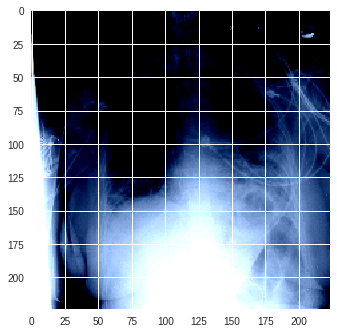

In [0]:
from PIL import Image, ImageFile
import matplotlib.image as mpimg

img_path = os.path.join(images1_folder, filenames_1[737])
img = Image.open(img_path).convert("RGB")
img_arr = np.asarray(img)
img_arr = img_arr.astype(np.float32)
img_arr = img_arr / 255.
imgplot = plt.imshow(img_arr)

img_arr = resize(img_arr, (224,224), mode='reflect')

mean = np.array([0.485, 0.456, 0.406 ])
std = np.array([0.229, 0.224, 0.225 ])
img_arr = img_arr - mean
img_arr = img_arr / std

imgplot = plt.imshow(img_arr)
print(img_arr.shape)

img_arr = np.fliplr(img_arr)
#imgplot = plt.imshow(img_arr)

#Preapare data and labels

In [0]:
def parse_data(df):
    """
    Read DataEntry2017 CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'image-name01': {
            'png': path/to/png/file,
            'label': list of labels, 
            'patient_gender': M or F
            'pattient_age': int
        },
        'image-name-02': {
            'png': path/to/png/file,
            'label': list of labels,
            'patient_gender': M or F
            'pattient_age': int
        }, ...

      }
      
    """
    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['Image Index']
        if pid not in parsed:
            labels = row['Finding Labels']
            parsed[pid] = {
                'png': '%s' % pid,
                'label': labels.split("|"),
                'patient_gender': row['Patient Gender'],
                'pattient_age': row['Patient Age']}
        
        #labels = row['Finding Labels']
        #parsed[pid]['label'].append(labels.split("|"))
        
    return parsed
  
  
df = pd.read_csv('/content/gdrive/My Drive/ChestXRay_csv/Data_Entry_2017.csv')
parsed = parse_data(df)


#Create the labels

In [0]:
def concrete_labels(parsed, filenames):
  n_labels = 14
  labels_array = np.zeros((len(filenames), n_labels), dtype=int) #4999 x 14
  dictionary = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltration':3, 
                'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7, 'Consolidation': 8,
               'Edema':9, 'Emphysema':10, 'Fibrosis': 11, 'Pleural_Thickening': 12, 'Hernia': 13}
  i = 0
  for item in filenames:
    diseases = parsed[item]['label']
    for d in diseases:
      if d == 'No Finding':
        pass
      else:
        j = dictionary[d]
        labels_array[i][j] = 1
    i += 1
  return labels_array


In [0]:
y_train = concrete_labels(parsed, train_filenames)
print(y_train[0])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
def get_label(filename, parsed):
  n_labels = 14
  label_array = np.zeros((1, n_labels), dtype=int) #1 x 14
  dictionary = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltration':3, 
                'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7, 'Consolidation': 8,
               'Edema':9, 'Emphysema':10, 'Fibrosis': 11, 'Pleural_Thickening': 12, 'Hernia': 13}
  diseases = parsed[filename]['label']
  for d in diseases:
      if d == 'No Finding':
        pass
      else:
        j = dictionary[d]
        label_array[0][j] = 1
  return label_array

yy = get_label('00000003_005.png', parsed)
print(yy[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, parsed, batch_size=BATCHSIZE, 
                 image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.parsed = parsed
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def __load__(self, filename):
      
        # load png file as numpy array
        img_path = os.path.join(self.folder, filename)
        img = Image.open(img_path).convert("RGB")
        img_arr = np.asarray(img)
        img_arr = img_arr.astype(np.float32)
        img_arr = img_arr / 255.  
        img_arr = resize(img_arr, (self.image_size, self.image_size), mode='reflect')
        mean = np.array([0.485, 0.456, 0.406 ])
        std = np.array([0.229, 0.224, 0.225 ])
        img_arr = img_arr - mean
        img_arr = img_arr / std
        
        #horizontal flip
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
        #label of img
        label = get_label(filename, self.parsed)[0]
        return img_arr, label
      
    def __loadpredict__(self, filename):
        # load png file as numpy array
        img_path = os.path.join(self.folder, filename)
        img = Image.open(img_path).convert("RGB")
        img_arr = np.asarray(img)
        img_arr = img_arr.astype(np.float32)
        img_arr = img_arr / 255.  
        img_arr = resize(img_arr, (self.image_size, self.image_size), mode='reflect')
        mean = np.array([0.485, 0.456, 0.406 ])
        std = np.array([0.229, 0.224, 0.225 ])
        img_arr = img_arr - mean
        img_arr = img_arr / std
        
        return img_arr
      
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, labels = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            labels = np.array(labels)
            return imgs, labels
#Shuffling the order in which examples are fed to the classifier is helpful 
#so that batches between epochs do not look alike. Doing so will eventually make our model more robust.
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

#Training

In [0]:
from keras.applications.densenet import DenseNet121

base_model = DenseNet121(input_shape=DIMS, weights='imagenet', include_top = False)

# add a global spatial average pooling layer
x = base_model.output
#x = keras.layers.BatchNormalization(momentum = MOMENTUM)(x)
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(14, activation='sigmoid')(x)

# this is the model we will train
model_1 = Model(inputs=base_model.input, outputs=predictions)

model_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/

In [0]:
#ImageFile.LOAD_TRUNCATED_IMAGES = True
model_1.compile(optimizer=keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999),
              loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
train_gen = generator(images3_folder, train_filenames, parsed, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(images1_folder, valid_filenames, parsed, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

In [0]:
history1 = model_1.fit_generator(train_gen, validation_data=valid_gen, 
                              epochs=EPOCHS, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
625/625 [==============================] - 4232s 7s/step - loss: 0.1630 - acc: 0.9543 - val_loss: 0.2794 - val_acc: 0.9406
Epoch 2/6
625/625 [==============================] - 965s 2s/step - loss: 0.1551 - acc: 0.9555 - val_loss: 0.2806 - val_acc: 0.9031
Epoch 3/6
625/625 [==============================] - 945s 2s/step - loss: 0.1509 - acc: 0.9556 - val_loss: 0.1995 - val_acc: 0.9405
Epoch 4/6
625/625 [==============================] - 884s 1s/step - loss: 0.1484 - acc: 0.9556 - val_loss: 0.2073 - val_acc: 0.9397
Epoch 5/6
625/625 [==============================] - 885s 1s/step - loss: 0.1462 - acc: 0.9557 - val_loss: 0.2225 - val_acc: 0.9395
Epoch 6/6
625/625 [==============================] - 912s 1s/step - loss: 0.1447 - acc: 0.9560 - val_loss: 0.2039 - val_acc: 0.9402


#Save model after training

In [0]:
# serialize model to JSON
model_json = model_1.to_json()
with open("/content/gdrive/My Drive/model_16_01.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_1.save_weights("/content/gdrive/My Drive/model_16_01.h5")
print("Saved model to disk")

Saved model to disk


#Import model that was saved

In [0]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/gdrive/My Drive/model_32_05.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/model_32_05.h5")
print("Loaded model from disk")

loaded_model.compile(optimizer=keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999),
              loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
print("Compile model from disk")

Loaded model from disk
Compile model from disk


#Testing and AUROC

##Build the test data and test labels

In [0]:
# create labels for the testing data
test_labels = concrete_labels(parsed, test_filenames)

#testing data
test_data = []
for filename in test_filenames:
  img_path = os.path.join(images1_folder, filename)
  img = Image.open(img_path).convert("RGB")
  img_arr = np.asarray(img)
  img_arr = img_arr.astype(np.float32)
  img_arr = img_arr / 255.  
  img_arr = resize(img_arr, (224, 224), mode='reflect')
  mean = np.array([0.485, 0.456, 0.406 ])
  std = np.array([0.229, 0.224, 0.225 ])
  img_arr = img_arr - mean
  img_arr = img_arr / std
  test_data.append(img_arr)
test_data = np.array(test_data)

print(test_data.shape)

(2900, 224, 224, 3)


##Evaluate test data

In [0]:
test = model_1.evaluate(test_data, test_labels, verbose=1)
print("Loss and Accuracy: ", test)


2900/2900 [==============================] - 27s 9ms/step
Loss and Accuracy:  [0.16033051135211154, 0.9561576428084538]


##Test data distribution with disease that will be used to calculate the AUROC score

In [0]:
dictionary = {'Atelectasis': 0, 'Cardiomegaly': 0, 'Effusion': 0, 'Infiltration':0, 
              'Mass': 0, 'Nodule': 0, 'Pneumonia': 0, 'Pneumothorax': 0, 'Consolidation': 0,
              'Edema':0, 'Emphysema':0, 'Fibrosis': 0, 'Pleural_Thickening': 0, 'Hernia': 0}
for filename in train_filenames:
  labels = parsed[filename]['label']
  for label in labels:
    if label == 'No Finding':
      pass
    else:
      dictionary[label] += 1

print(dictionary)

{'Atelectasis': 920, 'Cardiomegaly': 424, 'Effusion': 950, 'Infiltration': 1454, 'Mass': 376, 'Nodule': 555, 'Pneumonia': 104, 'Pneumothorax': 281, 'Consolidation': 359, 'Edema': 153, 'Emphysema': 158, 'Fibrosis': 175, 'Pleural_Thickening': 273, 'Hernia': 13}


##ROC curve and AUC score for one disease

In [0]:
# -------- Get the predictions of the testing data----------
test_pred = model_1.predict(test_data)

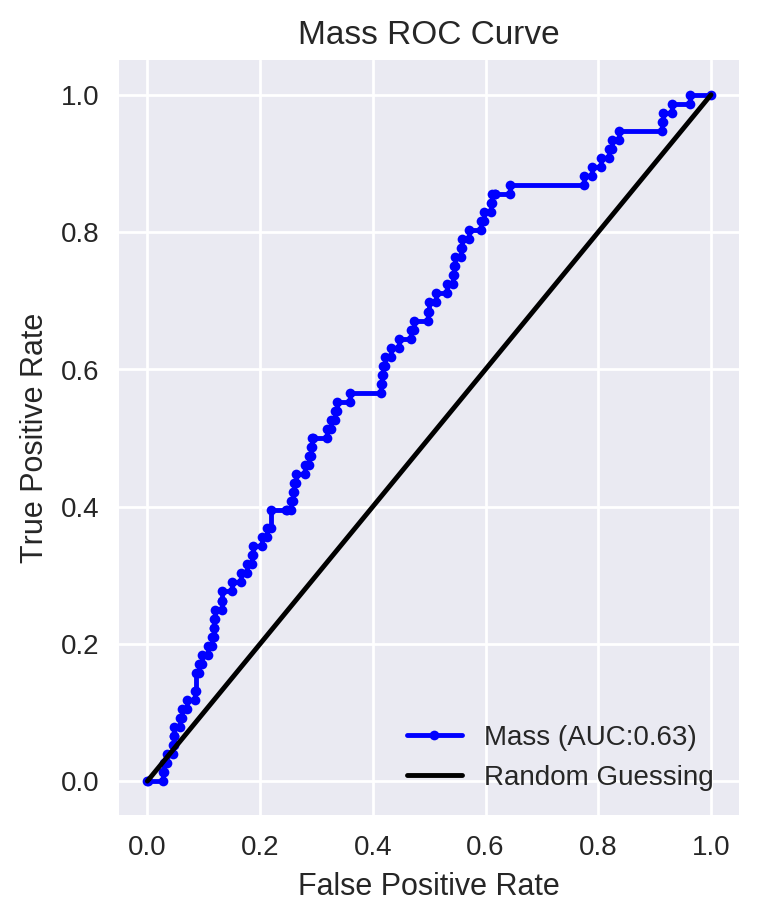

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_labels[:,4], test_pred[:,4])
fig, ax1 = plt.subplots(1,1, figsize = (4, 5), dpi = 200)
ax1.plot(fpr, tpr, 'b.-', label = 'Mass (AUC:%2.2f)' % roc_auc_score(test_labels[:,4], test_pred[:,4]))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Mass ROC Curve')
fig.savefig('roc_valid.pdf')

##ROC curve and AUC score for all disease

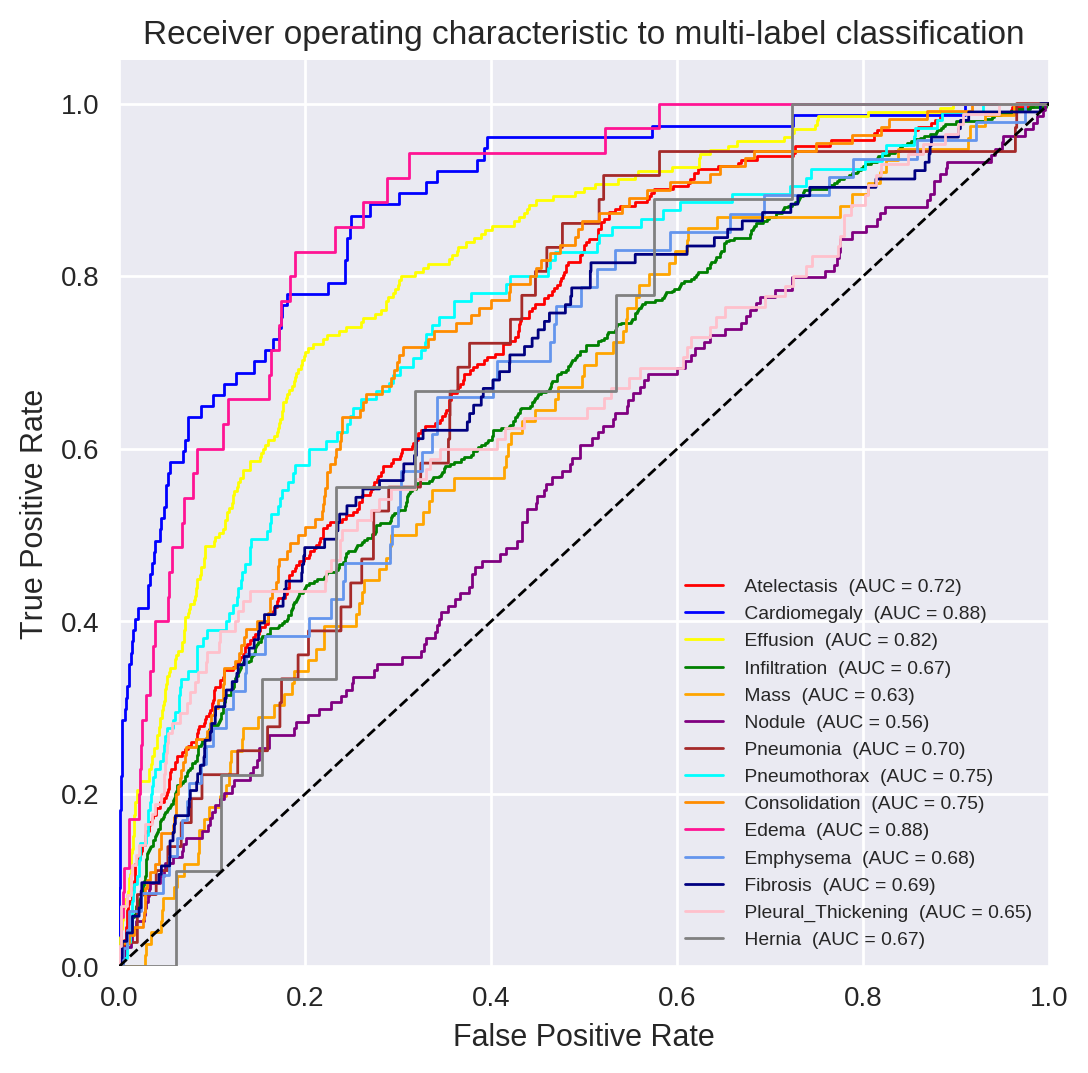

In [0]:
from itertools import cycle
from matplotlib.pyplot import figure

figure(num=None, figsize=(6, 6), dpi=200, facecolor='w', edgecolor='k')
lw = 1
average_auc_score = 0

labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
              'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
              'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

colors = cycle(['red','blue','yellow','green', 'orange','purple','brown','aqua','darkorange','deeppink','cornflowerblue','navy', 'pink', 'grey' ])
for i, color in zip(range(14), colors):
  fpr, tpr, _ = roc_curve(test_labels[:,i], test_pred[:,i])
  average_auc_score += roc_auc_score(test_labels[:,i], test_pred[:,i])
  plt.plot(fpr, tpr, color=color, lw=lw,
           label=' {0}  (AUC = {1:0.2f})'
           ''.format(labels[i], roc_auc_score(test_labels[:,i], test_pred[:,i])))

  
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-label classification')
plt.legend(loc="lower right",fontsize="xx-small")
plt.show()

In [0]:
print("AVERAGE AUC SCORE: ", average_auc_score/14)

AVERAGE AUC SCORE:  0.7183128722042156


#Results
###1)Training data: 4500 train, Validation data: 400, top = BatchNorm, AvgPool, Dense14
 - 1835s 13s/step - loss: 0.2058 - acc: 0.9386 - val_loss: 0.3003 - val_acc: 0.8793
 - 438s 3s/step - loss: 0.1729 - acc: 0.9517 - val_loss: 0.2224 - val_acc: 0.9328
 - 382s 3s/step - loss: 0.1710 - acc: 0.9519 - val_loss: 0.3448 - val_acc: 0.8733
 - 374s 3s/step - loss: 0.1701 - acc: 0.9518 - val_loss: 0.3032 - val_acc: 0.9422
 - 371s 3s/step - loss: 0.1699 - acc: 0.9519 - val_loss: 0.2196 - val_acc: 0.9414
 - 369s 3s/step - loss: 0.1674 - acc: 0.9519 - val_loss: 0.2334 - val_acc: 0.9347
 - 384s 3s/step - loss: 0.1669 - acc: 0.9521 - val_loss: 0.3315 - val_acc: 0.8893
 - 374s 3s/step - loss: 0.1664 - acc: 0.9520 - val_loss: 0.2684 - val_acc: 0.9414
 - 370s 3s/step - loss: 0.1647 - acc: 0.9521 - val_loss: 0.2084 - val_acc: 0.9422


###2)Training data: 4500 train, Validation data: 1000, top = AvgPool, Dense14
{'Atelectasis': 81, 'Cardiomegaly': 50, 'Effusion': 110, 'Infiltration': 177, 'Mass': 22, 'Nodule': 43, 'Pneumonia': 17, 'Pneumothorax': 22, 'Consolidation': 53, 'Edema': 25, 'Emphysema': 33, 'Fibrosis': 27, 'Pleural_Thickening': 36, 'Hernia': 3}

AUC scores: 
- Atelectasis 0.65
- Cardiomegaly 0.8
- Effusion 0.74
- Infiltration 0.7
- Mass 0.5
- Nodule 0.55
- Pneumonia 0.61
- Pneumothorax 0.43
- Consolidation 0.69
- Edema 0.89
- Emphysemia  0.53
- Fiborsis 0.56
- PT 0.41
- Hernia 0.73

AVERAGE AUC SCORE: 0.627

###3) Training data: 10000 train, Validation data: 1400, Test data = 2900, top = AvgPool, Dense14
Epochs: 12 , Learning Rate = 0.005

Train data: {'Atelectasis': 920, 'Cardiomegaly': 424, 'Effusion': 950, 'Infiltration': 1454, 'Mass': 376, 'Nodule': 555, 'Pneumonia': 104, 'Pneumothorax': 281, 'Consolidation': 359, 'Edema': 153, 'Emphysema': 158, 'Fibrosis': 175, 'Pleural_Thickening': 273, 'Hernia': 13}

Test data: {'Atelectasis': 262, 'Cardiomegaly': 77, 'Effusion': 205, 'Infiltration': 457, 'Mass': 76, 'Nodule': 134, 'Pneumonia': 36, 'Pneumothorax': 105, 'Consolidation': 110, 'Edema': 35, 'Emphysema': 47, 'Fibrosis': 103, 'Pleural_Thickening': 85, 'Hernia': 9}

AUC scores: 
- Atelectasis 0.66
- Cardiomegaly 0.6
- Effusion 0.70
- Infiltration 0.65
- Mass 0.55
- Nodule 0.6
- Pneumonia 0.6
- Pneumothorax 0.67
- Consolidation 0.7
- Edema 0.87
- Emphysemia  0.61
- Fiborsis 0.59
- PT 0.62
- Hernia 0.66

AVERAGE AUC SCORE:  0.6484264309188827

Loss and Accuracy:  [0.16625959684108865, 0.9571182301948811]



###4) Training data: 10000 train, Validation data: 1400, Test data = 2900, top = AvgPool, Dense14
Epochs: 12, Learning Rate = 0.001

Train data: {'Atelectasis': 920, 'Cardiomegaly': 424, 'Effusion': 950, 'Infiltration': 1454, 'Mass': 376, 'Nodule': 555, 'Pneumonia': 104, 'Pneumothorax': 281, 'Consolidation': 359, 'Edema': 153, 'Emphysema': 158, 'Fibrosis': 175, 'Pleural_Thickening': 273, 'Hernia': 13}

Test data: {'Atelectasis': 262, 'Cardiomegaly': 77, 'Effusion': 205, 'Infiltration': 457, 'Mass': 76, 'Nodule': 134, 'Pneumonia': 36, 'Pneumothorax': 105, 'Consolidation': 110, 'Edema': 35, 'Emphysema': 47, 'Fibrosis': 103, 'Pleural_Thickening': 85, 'Hernia': 9}

AUC scores: 
- Atelectasis 0.72
- Cardiomegaly 0.88
- Effusion 0.78
- Infiltration 0.67
- Mass  0.63
- Nodule  0.56
- Pneumonia 0.65
- Pneumothorax  0.69
- Consolidation 0.74
- Edema 0.81
- Emphysemia  0.65
- Fiborsis  0.72
- PT  0.70
- Hernia 0.58

AVERAGE AUC SCORE: 0.6984444673234022

Loss and Accuracy:  [0.17305679855675532, 0.9502216780596766]


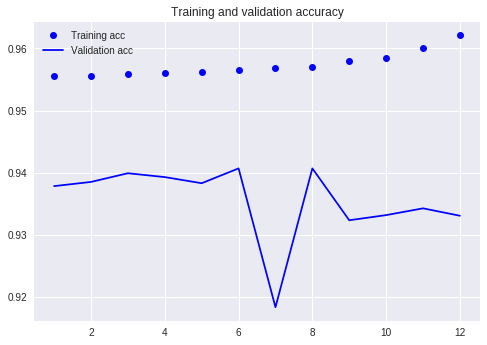

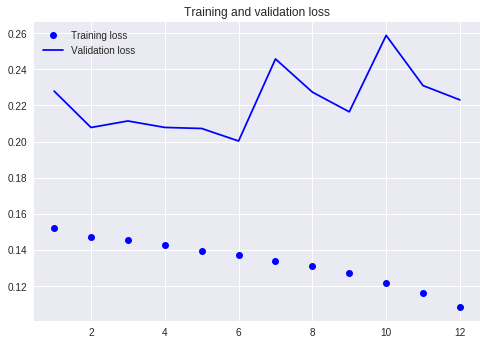

In [0]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Observations

1) Setting the batchsize=16, with training examples = 4500 and validation = 1000 gives slower results compared to batchsize = 32

2) If validation loss fluctuates too much then stop the training because results is poor results

3) Using smaller learning rate (0.001) we get better results, and the validation loss looks more stable but very close to model which was trained with learning rate (0.005) , and the training accuracy and loss has improved but it seems when I evaluate the test data separately the model with bigger learning rate looks better because the model was stopped after 12 epochs and we did not chose the to test the model with the lowest loss. 

Though the accuracy for training and validation remains very close, there is a big diffrence in the AUC score between the two models. A lower leanirng rate results in a better AUC score of the model, with a average score of 0.69, where the fisr one got a average score of 0.64
 